# Data Exploring

Data from: https://www.kaggle.com/datasets/felixzhao/productdemandforecasting

About Dataset


- Context

    The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.


- Content

    Historical Product Demand.csv - 
    CSV data file containing product demand for encoded product id's
    

- Acknowledgements

    This dataset is all real-life data and products/warehouse and category information encoded.


- Inspiration

    Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the the month after next?


* Input file: Historical Product Demand.csv 


* Description: CSV data file containing product demand for encoded product id's


* Size of Data: (1048575, 5)


* Features: Product_Code, Warehouse, Product_Category, Date, Order_Demand


* Period: 2011-01-08 ~ 2017-01-09

In [2]:
# DataFrame
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# EEMD
from PyEMD.EEMD import EEMD

# Prophet 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

# Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

Importing plotly failed. Interactive plots will not work.


## 데이터 로드 및 확인

In [3]:
df = pd.read_csv('Data\Historical Product Demand.csv')
df

KeyboardInterrupt: 

In [3]:
df['Order_Demand'].describe()

count     1048575
unique       3828
top         1000 
freq       112682
Name: Order_Demand, dtype: object

In [4]:
df.groupby('Warehouse').nunique()

,Product_Code,Product_Category,Date,Order_Demand
Warehouse,,,,
Whse_A,427,25,1577,1630
Whse_C,244,16,1345,1870
Whse_J,1625,25,1414,1899
Whse_S,553,28,1576,2157


In [5]:
df.groupby(['Warehouse', 'Product_Code']).nunique()

Product_Category  Date  Order_Demand
Warehouse Product_Code                                      
Whse_A    Product_0001                 1   198            29
          Product_0020                 1   430            28
          Product_0031                 1   390            28
          Product_0075                 1    63            10
          Product_0078                 1    67            31
...                                  ...   ...           ...
Whse_S    Product_2165                 1   152            47
          Product_2166                 1   255            58
          Product_2167                 1   382            94
          Product_2168                 1   113            52
          Product_2169                 1   151            55

[2849 rows x 3 columns]

In [6]:
df['Warehouse'].unique()

array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object)

In [7]:
# 데이터 확인
print('Size of Data:', df.shape)
print('')
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

Size of Data: (1048575, 5)

Product_Code: 2160
Warehouse: 4
Product_Category: 33
Date: 1729
Order_Demand: 3828


In [8]:
# 결측값 확인
df.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [9]:
#Drop na's.
# 결측치 행 1% 미만이라, drop 
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44795,Product_0965,Whse_A,Category_006,2011/11/18,1
44796,Product_0965,Whse_A,Category_006,2011/11/21,3
44797,Product_0965,Whse_A,Category_006,2011/11/21,5
44798,Product_0965,Whse_A,Category_006,2011/11/21,2
119561,Product_0980,Whse_A,Category_028,2011/11/21,100
107158,Product_0138,Whse_J,Category_007,2011/11/22,188
107159,Product_0138,Whse_J,Category_007,2011/11/22,1852
111727,Product_0982,Whse_A,Category_028,2011/11/22,3700
44102,Product_0980,Whse_A,Category_028,2011/11/23,1000
71915,Product_0980,Whse_A,Category_028,2011/11/23,200


In [10]:
#Target Feature - Order_Demand
# 종속 변수에 () 가 포함되어 있어, 모두 제거하고 int로 변환
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [11]:
# datetime dtype으로 변환
from datetime import datetime

df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d'))

In [12]:
# 2011년에 데이터가 거의 없어서 2012년부터로 데이터 조정
df = df[df['Date'] > '2012-01-01']

In [13]:
df.groupby('Warehouse').count()['Order_Demand']

Warehouse
Whse_A    142197
Whse_C     42219
Whse_J    764254
Whse_S     88025
Name: Order_Demand, dtype: int64

### 하루에 팔린 양을 모두 SUM

    - 'Product_Code', 'Date', 'Warehouse', 'Product_Category' 가 겹치는 중복되는 행을 하나로 합함

In [14]:
df = df.groupby(['Product_Code', 'Date', 'Warehouse', 'Product_Category'], as_index=False)['Order_Demand'].sum()
df

,Product_Code,Date,Warehouse,Product_Category,Order_Demand
0,Product_0001,2012-01-03,Whse_A,Category_005,1000
1,Product_0001,2012-01-04,Whse_A,Category_005,200
2,Product_0001,2012-01-05,Whse_J,Category_005,100
3,Product_0001,2012-01-09,Whse_A,Category_005,2000
4,Product_0001,2012-01-10,Whse_A,Category_005,3000
...,...,...,...,...,...
634016,Product_2172,2016-09-30,Whse_J,Category_005,100
634017,Product_2172,2016-10-21,Whse_J,Category_005,600
634018,Product_2172,2016-10-30,Whse_J,Category_005,300
634019,Product_2172,2016-11-24,Whse_J,Category_005,300


### Whse_J 공장으로 축소

In [15]:
df = df[df['Warehouse']=='Whse_J'].drop(columns='Warehouse')
df.reset_index(drop=True, inplace=True)

In [16]:
df.nunique()

Product_Code        1625
Date                1397
Product_Category      25
Order_Demand        4203
dtype: int64

In [17]:
df

,Product_Code,Date,Product_Category,Order_Demand
0,Product_0001,2012-01-05,Category_005,100
1,Product_0001,2012-01-10,Category_005,1000
2,Product_0001,2012-01-11,Category_005,200
3,Product_0001,2012-01-16,Category_005,100
4,Product_0001,2012-01-18,Category_005,800
...,...,...,...,...
431310,Product_2172,2016-09-30,Category_005,100
431311,Product_2172,2016-10-21,Category_005,600
431312,Product_2172,2016-10-30,Category_005,300
431313,Product_2172,2016-11-24,Category_005,300


In [27]:
product_df = df[df['Product_Code']=='Product_1378'].set_index('Date')
product_df.drop(['Product_Code', 'Product_Category'], axis=1, inplace=True)
product_df.head(10)

,Order_Demand
Date,
2012-01-05,149300
2012-01-06,152200
2012-01-10,48400
2012-01-11,33900
2012-01-12,26600
2012-01-13,1500
2012-01-16,86800
2012-01-17,178400
2012-01-18,52500


## ADI-CV
### ADI-CV를 통해 1625개 제품 중 8개 선별

- Average Demand Interval (ADI): 주문 사이의 평균 시간 간격
- Coefficient of Variation (CV): 평균과 표준 편차의 비율로서 변동성

In [201]:
def ADI(df):
    ADI_lst = list()
    for prod in df['Product_Code'].unique():
        tmp_df = df.loc[df['Product_Code'] == prod].reset_index(drop=True)
        dvList = list()
        for i in range(len(tmp_df)):
            if i == 0:
                date = 0
                dvList.append(date) # first element's intervel is zero
            else:
                date = (tmp_df.loc[i]['Date'] - tmp_df.loc[i-1]['Date']).days # interval days
                dvList.append(date)
        tv = sum(dvList) / len(dvList)
        ADI_lst.append(tv)
        
    return ADI_lst

In [202]:
def CV(df):
    CV_lst = list()
    for prod in df['Product_Code'].unique():
        tmp_df = df.loc[df['Product_Code'] == prod].reset_index(drop=True)['Order_Demand']
        cv = np.std(tmp_df)/(np.mean(tmp_df)+0.001)
        CV_lst.append(cv)
    
    return CV_lst

In [203]:
def ADI_CV(df):
    ADI_lst = ADI(df)
    CV_lst = CV(df)
    # The standards of classification (Intermittent, Lumpy, Smooth, Erratic)

    ADI_CV_df= pd.DataFrame({'Product_Code' : df['Product_Code'].unique(),
                           'ADI' : ADI_lst,
                           'CV' : CV_lst,})
    return ADI_CV_df

def func(df) :
    if (df['ADI'] >= 0 ) & (df['ADI'] <= adi_median) & (df['CV'] >= 0 ) & (df['CV'] <= cv_median )  :
        return "Smooth"
    if (df['ADI'] > adi_median) & (df['CV'] > 0 ) & (df['CV'] < cv_median )  :
        return "Intermittent"
    if (df['ADI'] >= 0 ) & (df['ADI'] <= adi_median) & (df['CV'] >= cv_median )  :
        return "Lumpy"
    if (df['ADI'] > adi_median) & (df['CV'] > cv_median )  :
        return "Erratic"

#### ADI-CV 이후, 수요 패턴 분석

In [154]:
ADI_CV_df = ADI_CV(df)
adi_median = np.median(ADI_CV_df['ADI'])
cv_median = np.median(ADI_CV_df['CV'])
ADI_CV_df['Demand_pattern'] = ADI_CV_df.apply(lambda x : func(x), axis=1)

In [155]:
ADI_CV_df

,Product_Code,ADI,CV,Demand_pattern
0,Product_0001,5.842444,1.044662,Smooth
1,Product_0003,8.099099,1.182429,Smooth
2,Product_0004,6.711610,1.383599,Lumpy
3,Product_0005,31.346154,1.050158,Intermittent
4,Product_0006,47.030303,0.518025,Intermittent
...,...,...,...,...
1620,Product_2167,2.554775,2.075101,Lumpy
1621,Product_2168,4.170901,1.881390,Lumpy
1622,Product_2169,8.450704,1.748541,Lumpy
1623,Product_2171,3.550098,1.420308,Lumpy


### 수요 데이터의 공백 확인

    - EX) 일주일 동안 팔린 기록이 하나라도 있었는지를 확인함.

In [157]:
def check_data(df):
    week_df = pd.DataFrame(columns=['Product_Code', 'Weeks'])
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    
    products = df['Product_Code'].unique()
    continuous_lst = []
    
    for product in products:
        tmp_df = df[df['Product_Code'] == product].sort_values(by='Date')
        tmp_df['week'] = tmp_df['Date'].dt.to_period('W')
        
        # 데이터가 하나라도 존재하는 week이 개수
        unique_weeks = tmp_df['week'].nunique()
        week_tmp_df = pd.DataFrame({'Product_Code': [product], 'Weeks': [unique_weeks]})
        week_df = pd.concat([week_df, week_tmp_df])
    week_df.sort_values(by='Weeks', ascending=False, inplace=True)
    week_df.reset_index(drop=True, inplace=True)
    return week_df

In [158]:
start_date = df['Date'].min()
end_date = df['Date'].max()
print('데이터의 전체 Weeks: ', (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days // 7, '주')

데이터의 전체 Weeks:  261 주


In [159]:
# 제품을 Weeks수와 CV를 기준으로 상위 N개의 품목을 추려냄
def select_products(ADI_CV_df, week_df, Num): # @Num: 선별하고자 하는 제품 수
    tmp_df = pd.merge(ADI_CV_df, week_df, on='Product_Code')
    new_df.sort_values(['Weeks', 'CV'], ascending=[False, True], inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    products_lst = new_df['Product_Code'][:Num].tolist()
    
    return products_lst # a list of products

In [160]:
week_df = check_data(df)
week_df

,Product_Code,Weeks
0,Product_1274,260
1,Product_1451,260
2,Product_1248,259
3,Product_1356,259
4,Product_1359,259
...,...,...
1620,Product_0244,6
1621,Product_0234,4
1622,Product_0233,4
1623,Product_0853,1


### 전체 날짜에 수요 분포가 있는 제품 확인

In [156]:
end_product = df[(df['Date']>'2017-01-01')]['Product_Code'].unique()
start_product = df[(df['Date']<'2017-01-10')]['Product_Code'].unique()
entire_product = set(end_product) & set(start_product)
entire_product = list(entire_product)

In [56]:
df.nunique()

Product_Code        1625
Date                1397
Product_Category      25
Order_Demand        4203
dtype: int64

### 제품의 카테고리 df 생성

In [122]:
categories = df['Product_Category'].unique()
category_map = {}

for category in categories:
    product_codes = df[df['Product_Category'] == category]['Product_Code'].unique()
    for product_code in product_codes:
        category_map[product_code] = category

cat_df = pd.DataFrame.from_dict(category_map, orient='index', columns=['Product_Category'])
cat_df.index.name = 'Product_Code'

In [124]:
cat_df = new_df.reset_index()
cat_df

,Product_Code,Product_Category
0,Product_0001,Category_005
1,Product_0003,Category_005
2,Product_0004,Category_005
3,Product_0005,Category_005
4,Product_0006,Category_005
...,...,...
1620,Product_1777,Category_010
1621,Product_1779,Category_010
1622,Product_1815,Category_031
1623,Product_1816,Category_031


In [165]:
#ADI_CV_df = ADI_CV_df[ADI_CV_df['Product_Code'].isin(entire_product)]
m_df = pd.merge(ADI_CV_df[(ADI_CV_df['ADI']<4) & (ADI_CV_df['CV']<2)].sort_values(by='CV'), cat_df, on='Product_Code')
m_df = pd.merge(m_df, week_df, on='Product_Code')

### 최종 선별 품목 8개

In [204]:
product_lst = ['Product_1248',
               'Product_1295',
               'Product_0025',
               'Product_1378',
               'Product_2004',
               'Product_1154',
               'Product_0739',
               'Product_0901']

m_df[m_df['Product_Code'].isin(product_lst)]

,Product_Code,ADI,CV,Demand_pattern,Product_Category,Weeks
2,Product_1295,1.494659,0.641131,Smooth,Category_019,258
3,Product_1378,1.490581,0.665497,Smooth,Category_019,258
9,Product_2004,3.198944,0.748228,Smooth,Category_005,245
14,Product_1154,3.349353,0.775036,Smooth,Category_006,242
24,Product_0739,3.384328,0.886617,Smooth,Category_001,236
35,Product_0901,3.147059,0.979048,Smooth,Category_023,216
58,Product_0025,1.989119,1.083912,Smooth,Category_005,259
117,Product_1248,1.512053,1.300047,Lumpy,Category_019,259


In [205]:
df = df[df['Product_Code'].isin(product_lst)]
df.reset_index(drop=True)

,Product_Code,Date,Product_Category,Order_Demand
0,Product_0025,2012-01-05,Category_005,1600
1,Product_0025,2012-01-06,Category_005,1000
2,Product_0025,2012-01-10,Category_005,600
3,Product_0025,2012-01-11,Category_005,800
4,Product_0025,2012-01-12,Category_005,600
...,...,...,...,...
6778,Product_2004,2016-12-20,Category_005,6000
6779,Product_2004,2016-12-21,Category_005,7000
6780,Product_2004,2016-12-22,Category_005,1000
6781,Product_2004,2016-12-26,Category_005,2000


## 상위 15개 품목의 시계열 그래프 그리기

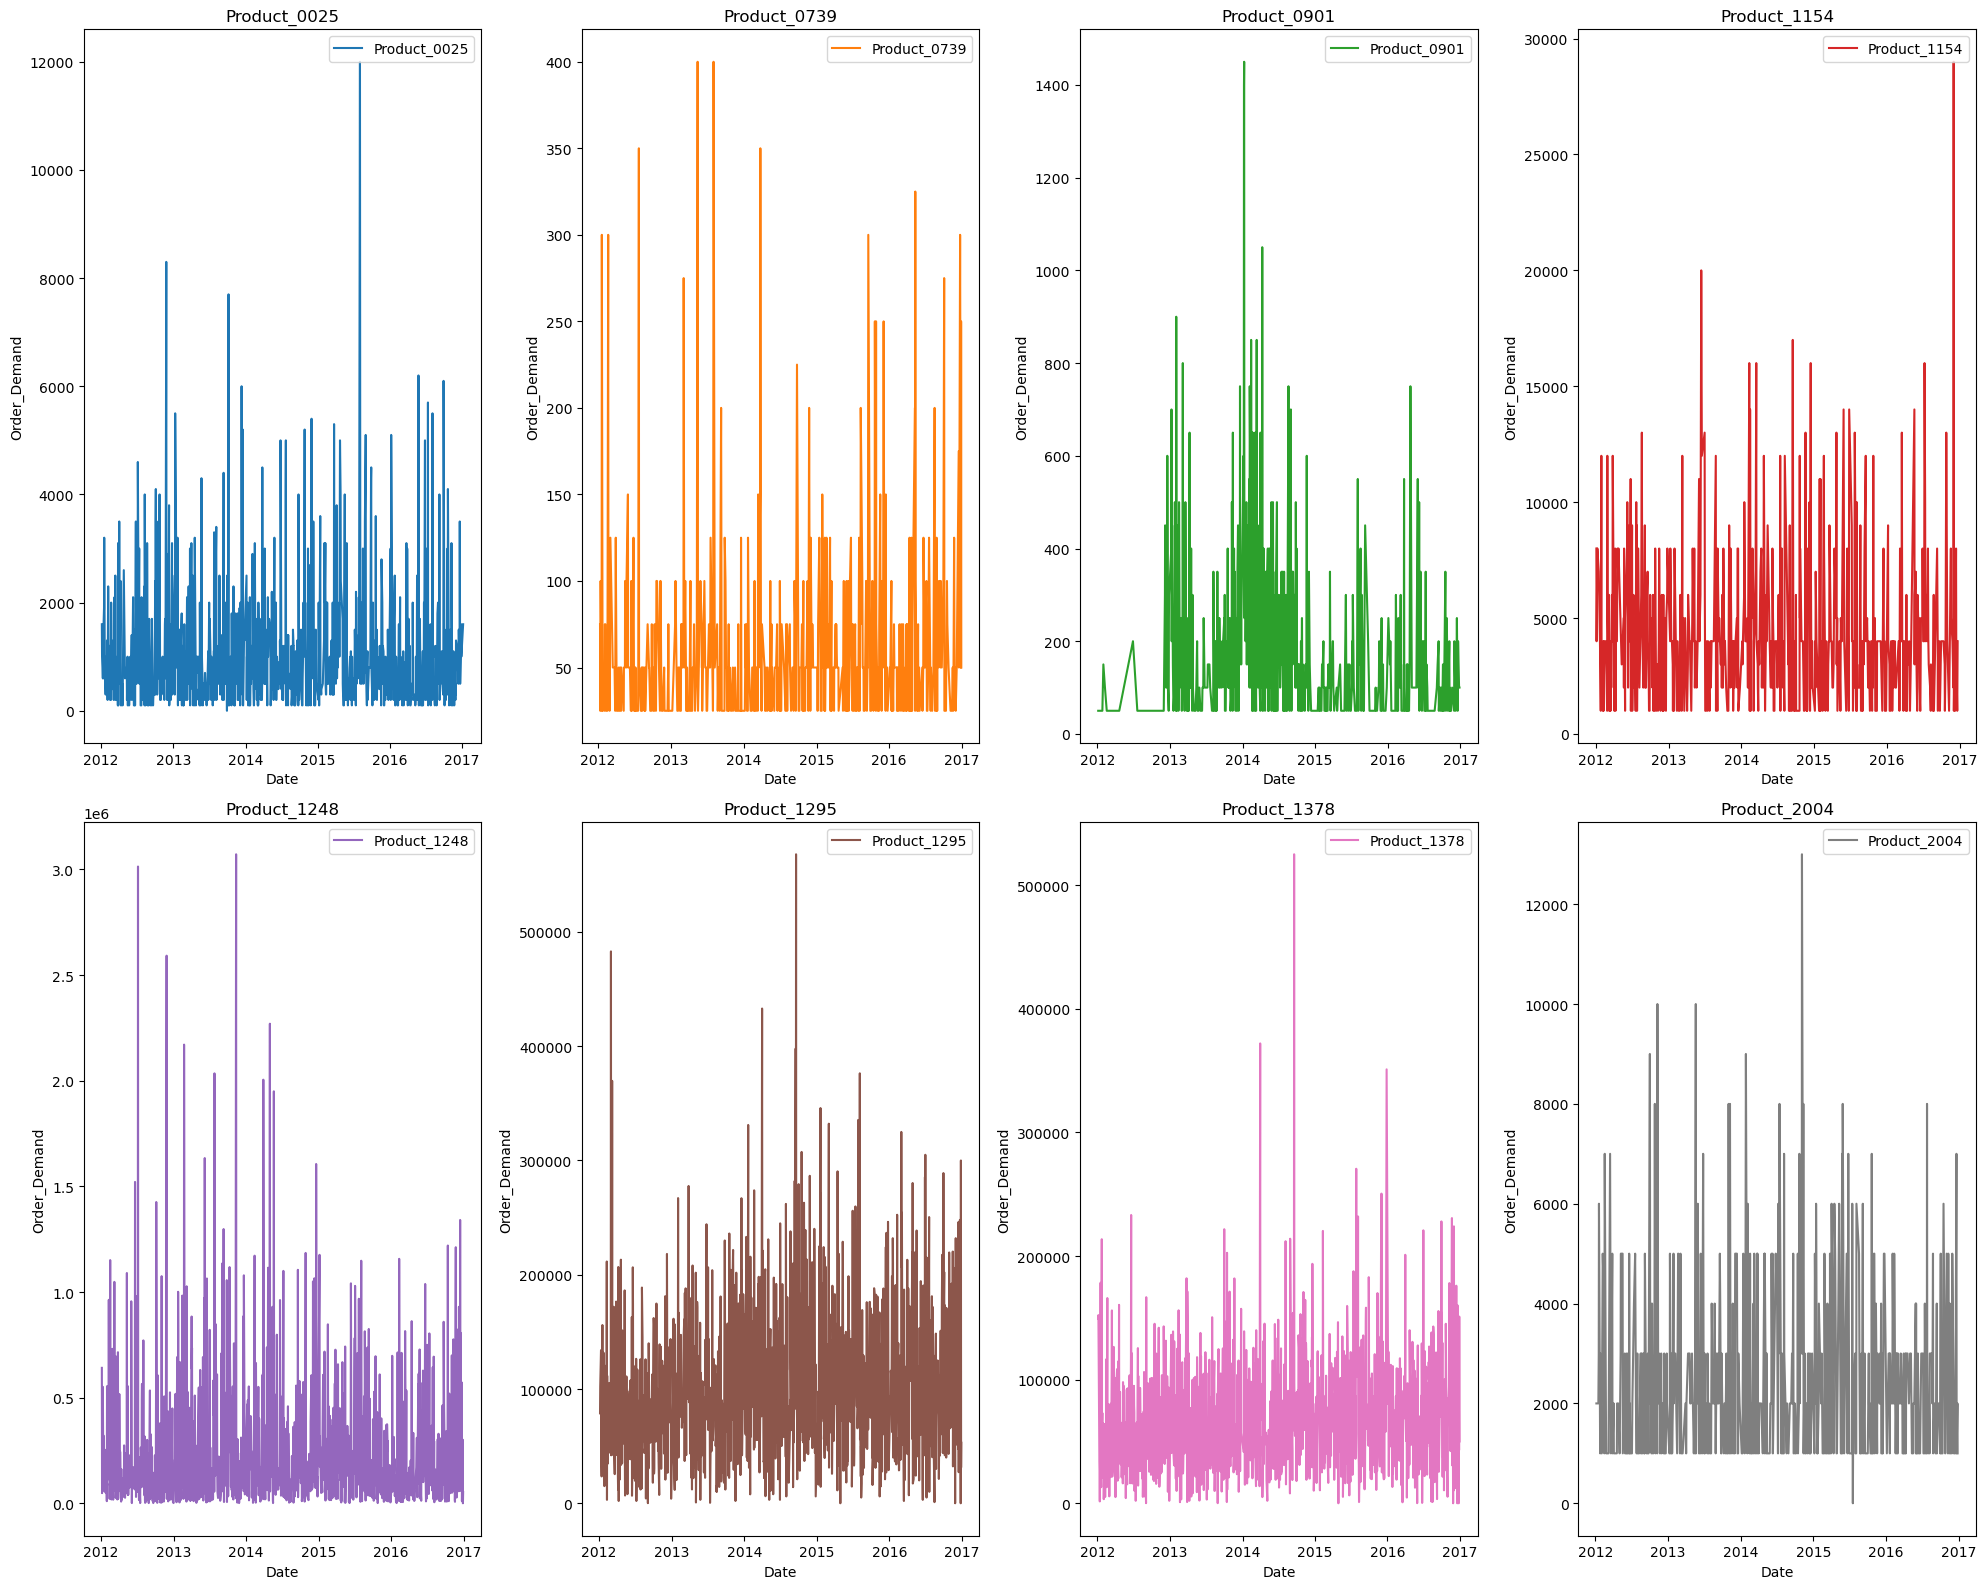

In [206]:
def plot_time(df):
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 16))
    
    for idx, code in enumerate(df['Product_Code'].unique()):
        row, col = idx // 4, idx % 4
        tmp_df = df[df['Product_Code'] == code][['Date', 'Order_Demand']]
        axs[row, col].plot(tmp_df['Date'], tmp_df['Order_Demand'], label=code, color=f'C{idx}')
        axs[row, col].set_title(code)
        axs[row, col].set_xlabel('Date')
        axs[row, col].set_ylabel('Order_Demand')
        axs[row, col].legend()

    fig.tight_layout()
    plt.show()

# 상위 15개 품목의 시계열 그래프 그리기
plot_time(df)

### 판매가 없는 Date의 Order_Demand를 0으로 채움

In [207]:
def fill_zero(df):
    new_df = pd.DataFrame()
    for i,code in enumerate(df['Product_Code'].unique()):
        #print(f'{i}/{df['Product_Code'].nunique()}')
        category = df[df['Product_Code']==code]['Product_Category'].unique()[0]
        tmp_df = df.groupby('Product_Code').get_group(code)
        
        start_date = tmp_df['Date'].min()
        end_date = tmp_df['Date'].max()
        # full range of Date
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        date_df = pd.DataFrame(date_range, columns=['Date'])
        # 기존 데이터와 새로운 DataFrame을 병합하고 Order_Demand를 0으로 채웁니다.
        merged_df = pd.merge(date_df, tmp_df, on='Date', how='left')
        merged_df['Order_Demand'].fillna(0, inplace=True)
        merged_df['Product_Code'].fillna(code, inplace=True)
        merged_df['Product_Category'].fillna(category, inplace=True)
        #merged_df['Warehouse'].fillna(method='ffill', inplace=True)
        
        new_df = pd.concat([new_df, merged_df], axis=0, ignore_index=True)

    return new_df

In [183]:
df[df['Product_Code']=='Product_0025']

,Date,Product_Code,Product_Category,Order_Demand
0,2012-01-05,Product_0025,Category_005,1600.0
1,2012-01-06,Product_0025,Category_005,1000.0
2,2012-01-07,Product_0025,Category_005,0.0
3,2012-01-08,Product_0025,Category_005,0.0
4,2012-01-09,Product_0025,Category_005,0.0
...,...,...,...,...
1824,2017-01-02,Product_0025,Category_005,0.0
1825,2017-01-03,Product_0025,Category_005,0.0
1826,2017-01-04,Product_0025,Category_005,0.0
1827,2017-01-05,Product_0025,Category_005,0.0


### 수요가 없는 날을 0으로 채움

In [208]:
df = fill_zero(df)
df

,Date,Product_Code,Product_Category,Order_Demand
0,2012-01-05,Product_0025,Category_005,1600.0
1,2012-01-06,Product_0025,Category_005,1000.0
2,2012-01-07,Product_0025,Category_005,0.0
3,2012-01-08,Product_0025,Category_005,0.0
4,2012-01-09,Product_0025,Category_005,0.0
...,...,...,...,...
14551,2016-12-23,Product_2004,Category_005,0.0
14552,2016-12-24,Product_2004,Category_005,0.0
14553,2016-12-25,Product_2004,Category_005,0.0
14554,2016-12-26,Product_2004,Category_005,2000.0


In [209]:
# 파일 저장
df.to_csv('HPD_0416.csv', index=False)

In [ ]:
# 한글만 추출하는 함수
def extract_korean(text):
    return ''.join(re.findall('[가-힣]+', text))

# Product 열에 함수 적용
df['Product'] = df['Product'].apply(extract_korean)

In [ ]:
# 이상치를 중앙값으로 대치하는 함수
def replace_upper_outliers_with_median(group):
    Q1 = group['y'].quantile(0.25)
    Q3 = group['y'].quantile(0.75)
    IQR = Q3 - Q1
    median = group['y'].median()
    
    # Q3 + IQR*1.5 보다 큰 값을 이상치로 판정
    outlier_mask = group['y'] > (Q3 + 1.5*IQR)
    
    # 이상치를 중앙값으로 대치
    group.loc[outlier_mask, 'y'] = median
    return group

In [ ]:
df = df.groupby('Product').apply(replace_upper_outliers_with_median).reset_index(drop=True)